In [1]:
import numpy as np
import ctypes, time, os
from ipywidgets import interact, widgets

# Import visualization stuff
import matplotlib.pyplot as plt
import nibabel as nib
from nilearn import plotting

# Import popeye stuff
import popeye.utilities_cclab as utils
from popeye.visual_stimulus import VisualStimulus, simulate_bar_stimulus, resample_stimulus
from popeye.spinach import generate_og_receptive_fields
import popeye.models_cclab as prfModels

# Import multiprocessing stuff
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor

# Load helper functions
from dataloader import set_paths, load_stimuli, copy_files
%load_ext autoreload
%autoreload 2

In [2]:
# Initialize parameters
params = {}
params['subjID'] = 'JC'
# Got these from Zhengang, and he got it from rsvp_params.txt
params['viewingDistance'] = 63 #83.5 # in cm
params['screenWidth'] = 35 #36.2 # in cm
params['scaleFactor'] = 1#0.1
params['resampleFactor'] = 1#1080/120
params['dtype'] = ctypes.c_int16

p = set_paths(params)

In [3]:
bar, stim_params = load_stimuli(p)
bar = bar[:, :, 0:201]
# Mirror y axis (this is done because popeye flips the y axis)
bar = np.flip(bar, axis=0)

# bar = resample_stimulus(bar, params['resampleFactor'])

copy_files(p, params)

# Extract number of TRs
method = 'ss5'

func_data = nib.load(p['pRF_' + method])
f_header = func_data.header
params['tr_length'] = f_header['pixdim'][4]
params['voxel_size'] = [f_header['pixdim'][i] for i in range(1, 4)]
params['nTRs'] = func_data.shape[-1]

# model to fit to
scan_data = func_data.get_fdata()
# scan_data = utils.percent_change(scan_data, ax=-1) # Convert to pct signal change

# Ground truth model-fit from mrVista
popeye_fit_path = os.path.join(p['pRF_data'], 'JC', 'mrVistaFit', 'RF_' + method + '-fFit.nii.gz')
mrVista_fit = nib.load(popeye_fit_path).get_fdata()

brainmask_data = nib.load(p['pRF_brainmask']).get_fdata() != 0
# Resample brainmask if first 2 dimensions are twice the third dimension
if brainmask_data.shape[0] == 2*brainmask_data.shape[2]:
    brainmask_data = brainmask_data[::2, ::2, :]

Subject folder already exists


In [4]:
# create stimulus object from popeye
stimulus = VisualStimulus(bar.astype('int16'),
                          params['viewingDistance'],
                          params['screenWidth'],
                          params['scaleFactor'],
                          params['tr_length'],
                          params['dtype'],
)
                        #  'blinear')

In [ ]:
print(stimulus.ppd, stimulus.ppd0)

In [ ]:
# Crete an animation through time for stimulus.stim_arr whose third axis is time
def animate(time):
    plt.imshow(stimulus.stim_arr[:, :, time], cmap='gray')
    plt.show()

interact(animate, time=widgets.IntSlider(min=0, max=stimulus.stim_arr.shape[-1]-1, step=1, value=0))

In [24]:
# Testing only on visual ROIs
# Load visual ROIs
lh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V1.nii.gz')).get_fdata()
lh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V2d.nii.gz')).get_fdata()
lh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3d.nii.gz')).get_fdata()
lh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'lh.V3AB.nii.gz')).get_fdata()
rh_v1 = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V1.nii.gz')).get_fdata()
rh_v2d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V2d.nii.gz')).get_fdata()
rh_v3d = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3d.nii.gz')).get_fdata()
rh_v3ab = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'roi_mdd', 'rh.V3AB.nii.gz')).get_fdata()
# Combine all ROIs using boolean OR
visual_rois = lh_v1 + lh_v2d + lh_v3d + lh_v3ab + rh_v1 + rh_v2d + rh_v3d + rh_v3ab
visual_rois = visual_rois > 0
visual_rois = lh_v1 #+ rh_v1 #+ lh_v2d + rh_v2d
visual_rois = visual_rois > 0

trueFit_data = nib.load(os.path.join(p['pRF_data'], params['subjID'], 'mrVistaFit/RF_ss5-fFit.nii.gz')).get_fdata()
r2_data = trueFit_data[:, :, :, 1]
r2visual_data = r2_data[visual_rois]
r2sorted = np.sort(r2visual_data.flatten())[::-1]
nvoxs = 25
r2thresh = r2sorted[nvoxs]
visual_rois = r2_data > r2thresh

In [ ]:
# # Run the fit
# start_time = time.time()
# ncpu = 1#int(os.environ.get('SLURM_CPUS_PER_TASK',default=1))
# print(f"Popeye will analyze {np.sum(visual_rois)} voxels using {ncpu} CPUs")
# pool = mp.Pool(ncpu)
# output = pool.map(utils.parallel_fit, bundle)
# # with mp.Pool(ncpu) as pool:
# #     results = list(tqdm.tqdm(pool.imap(utils.parallel_fit, bundle), total=len(bundle), desc='Fitting pRFs'))
# pool.close()
# pool.join()
# end_time = time.time()

In [31]:
css_model = prfModels.CompressiveSpatialSummationModel(stimulus, utils.double_gamma_hrf, normalizer=utils.percent_change)
css_model.hrf_delay = 0
css_model.mask_size = 5 # standard deviations of the gaussian

# Create scan data just for visual ROIs
scan_data_visual = scan_data.copy()
scan_data_visual[~visual_rois] = 0

[xi, yi, zi] = np.nonzero(visual_rois)
indices = [(xi[i], yi[i], zi[i]) for i in range(len(xi))]
num_voxels = len(indices)
timeseries_data = scan_data_visual[xi, yi, zi, :]

# set search grids
Ns = 5
x_grid = utils.grid_slice(-10.0, 10.0, Ns)
y_grid = utils.grid_slice(-10.0, 10.0, Ns)
s_grid = utils.grid_slice(1/css_model.stimulus.ppd0, 5.25, Ns)
n_grid = utils.grid_slice(0.25, 1, Ns)
grids = (x_grid, y_grid, s_grid, n_grid,)

# Set search bounds
x_bounds = (-15.0, 15.0)
y_bounds = (-15.0, 15.0)
s_bounds = (1/css_model.stimulus.ppd0, 5.0)
n_bounds = (0.2, 1)
b_bounds = (1e-8, None)
m_bounds = (None, None)
bounds = (x_bounds, y_bounds, s_bounds, n_bounds, b_bounds, m_bounds)

verbose = 0
auto_fit = 1

In [23]:
n_grid

slice(0.25, 1.25, 0.25)

In [32]:
# Create a result holder
RF_ss5_gFit = np.empty((scan_data_visual.shape[0], scan_data_visual.shape[1], scan_data_visual.shape[2], 8))
RF_ss5_fFit = np.empty((scan_data_visual.shape[0], scan_data_visual.shape[1], scan_data_visual.shape[2], 8))
vx_indices = np.argwhere(visual_rois)

In [33]:
def process_voxel(ix, iy, iz):
    if visual_rois[ix, iy, iz] == 1:
        th_vx_idx = np.where((vx_indices == (ix, iy, iz)).all(axis=1))[0][0]
        if np.mod(th_vx_idx, 100) == 0:
            run_time = time.time() - start_time
            if run_time < 60:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {round(run_time, 2)} s")
            elif run_time < 3600:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {int(np.floor(run_time/60))} min {round(run_time%60)} s")
            else:
                print(f"Finished: {round(th_vx_idx/len(vx_indices)*100, 2)}%, time: {int(np.floor(run_time/3600))} h {int(np.floor(run_time%3600/60))} min {round(run_time%60)} s")
        voxel_data = scan_data[ix, iy, iz, :]
        fit = prfModels.CompressiveSpatialSummationFit(
            css_model,
            voxel_data,
            grids,
            bounds,
            (ix, iy, iz),
            auto_fit=auto_fit,
            grid_only=False,
            verbose=verbose
        )
        #return (ix, iy, iz, fit.theta, fit.rsquared, fit.rho, fit.sigma, fit.x, fit.y, fit.beta)
        return (ix, iy, iz, fit.theta0, fit.rsquared0, fit.rho0, fit.s0, fit.n0, fit.x0, fit.y0, fit.beta0,
                            fit.theta, fit.rsquared, fit.rho, fit.sigma, fit.n, fit.x, fit.y, fit.beta)
    
    return None

start_time = time.time()

futures = []
with ThreadPoolExecutor() as executor:
    for ix in range(visual_rois.shape[0]):
        for iy in range(visual_rois.shape[1]): 
            for iz in range(visual_rois.shape[2]):
                futures.append(executor.submit(process_voxel, ix, iy, iz))

results = [f.result() for f in futures]

for result in results:
    if result is not None:
        ix, iy, iz, theta0, rsquared0, rho0, sigma0, n0, x0, y0, beta0, theta, rsquared, rho, sigma, n, x, y, beta = result
        # Get the grid fit estimates
        RF_ss5_gFit[ix, iy, iz, 0] = theta0
        RF_ss5_gFit[ix, iy, iz, 1] = rsquared0
        RF_ss5_gFit[ix, iy, iz, 2] = rho0
        RF_ss5_gFit[ix, iy, iz, 3] = sigma0
        RF_ss5_gFit[ix, iy, iz, 4] = n0
        RF_ss5_gFit[ix, iy, iz, 5] = x0
        RF_ss5_gFit[ix, iy, iz, 6] = y0
        RF_ss5_gFit[ix, iy, iz, 7] = beta0

        # Get the full fit estimates
        RF_ss5_fFit[ix, iy, iz, 0] = theta
        RF_ss5_fFit[ix, iy, iz, 1] = rsquared
        RF_ss5_fFit[ix, iy, iz, 2] = rho
        RF_ss5_fFit[ix, iy, iz, 3] = sigma
        RF_ss5_fFit[ix, iy, iz, 4] = n
        RF_ss5_fFit[ix, iy, iz, 5] = x
        RF_ss5_fFit[ix, iy, iz, 6] = y
        RF_ss5_fFit[ix, iy, iz, 7] = beta

end_time = time.time()
print()
print(f"Time taken for fitting: {end_time - start_time}")

Finished: 0.0%, time: 17.88 s

Time taken for fitting: 286.3101341724396


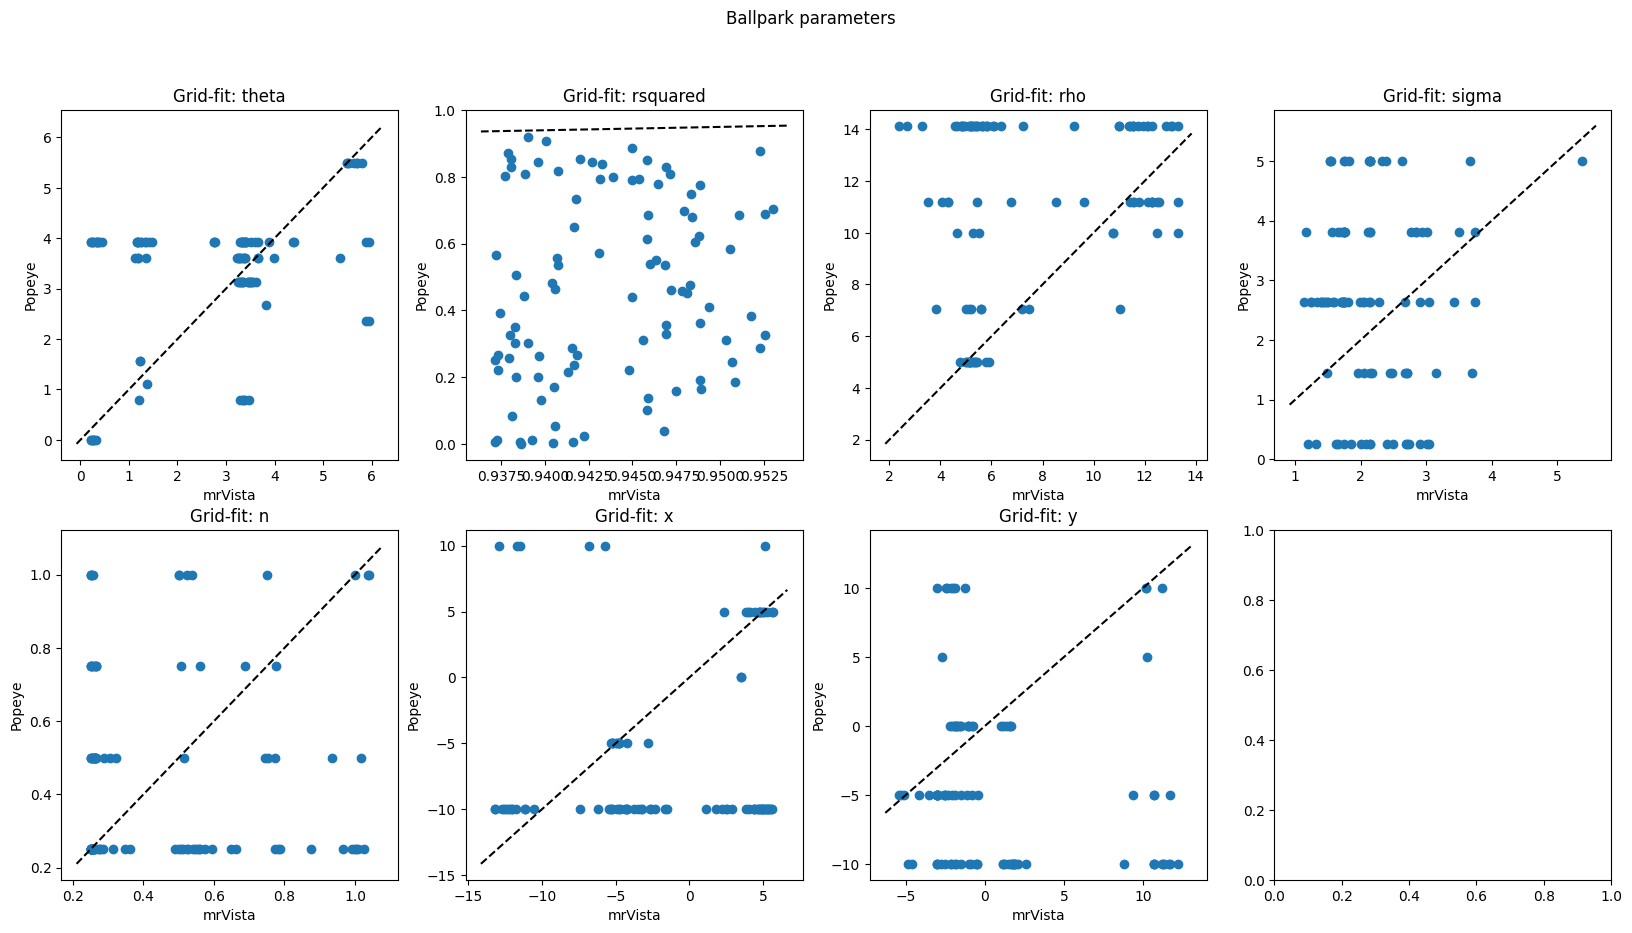

In [30]:
# Plot ground_truth and estimated parameters
f, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(7):
    ax = axs.flatten()[i]
    # this_truth = trueFit_data[visual_rois, i]
    ax.plot(trueFit_data[visual_rois, i].flatten(), RF_ss5_gFit[visual_rois, i].flatten(), 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Grid-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('mrVista')
    ax.set_ylabel('Popeye')
plt.suptitle("Ballpark parameters")
plt.show()

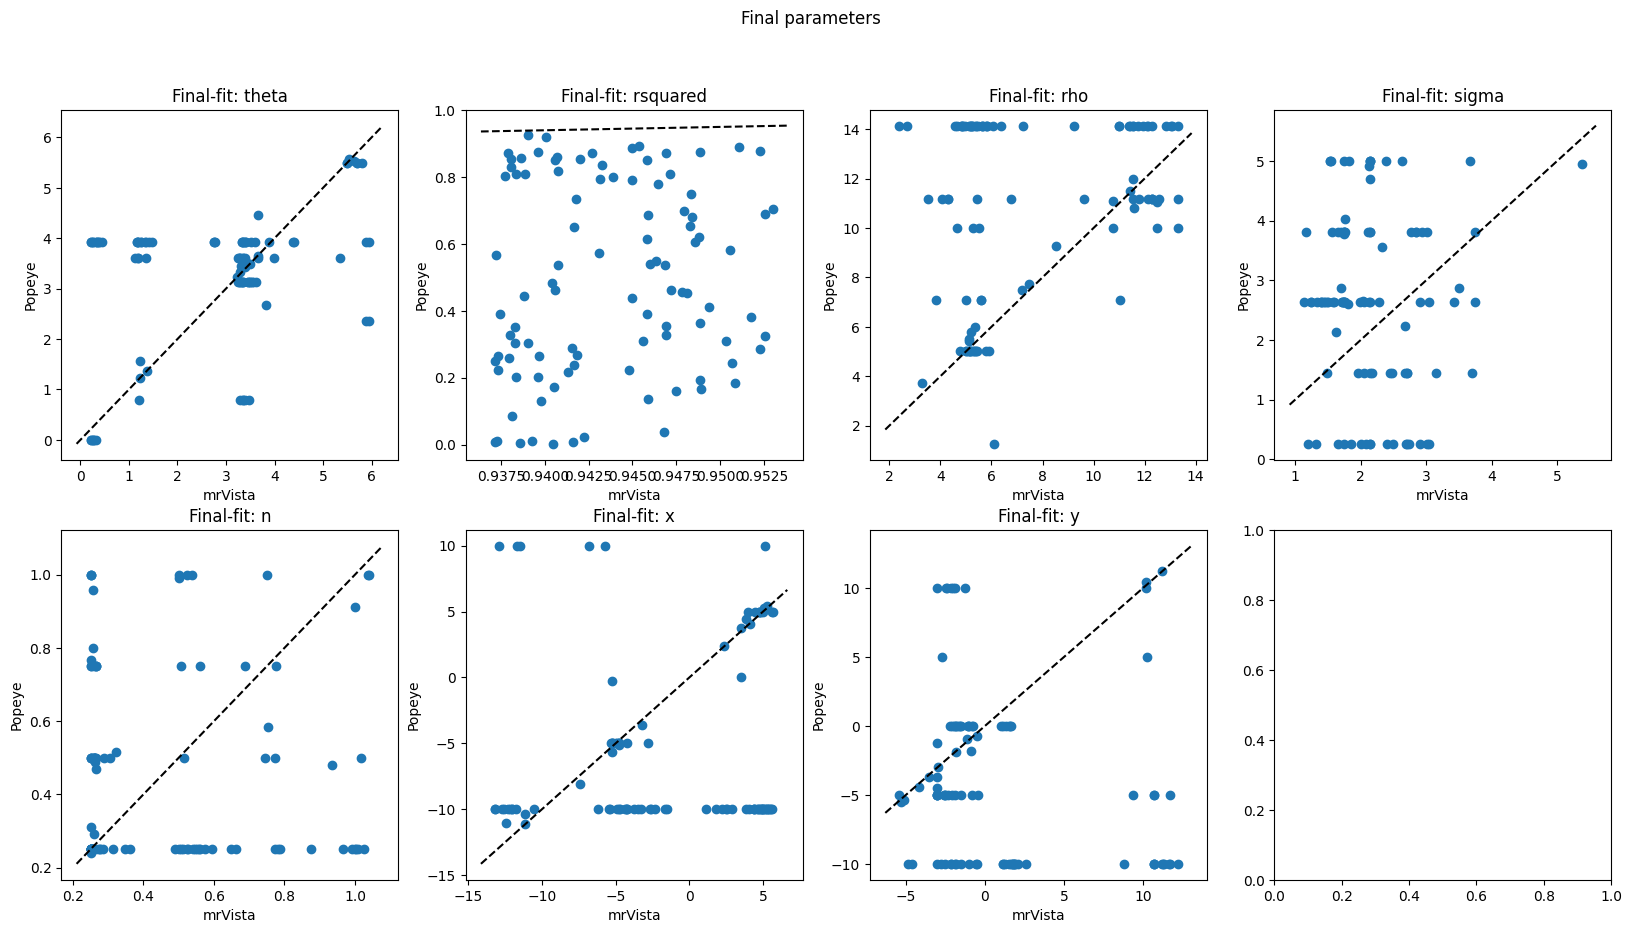

In [29]:
# Plot ground_truth and estimated parameters
f, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(7):
    ax = axs.flatten()[i]
    # this_truth = trueFit_data[visual_rois, i]
    ax.plot(trueFit_data[visual_rois, i].flatten(), RF_ss5_fFit[visual_rois, i].flatten(), 'o')
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')
    ax.set_title(f"Final-fit: {['theta', 'rsquared', 'rho', 'sigma','n', 'x', 'y', 'beta'][i]}")
    ax.set_xlabel('mrVista')
    ax.set_ylabel('Popeye')
plt.suptitle("Final parameters")
plt.show()

In [ ]:
# # Save the results
# anat_data = nib.load(p['pRF_anat']) #.get_fdata()
# popeye_fit = nib.Nifti1Image(RF_ss5_fFit, affine=anat_data.affine, header=anat_data.header)
# popeye_fit = nib.nifti1.Nifti1Image(RF_ss5_fFit, affine=func_data.affine, header=func_data.header)
# if not os.path.exists(os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit')):
#     os.makedirs(os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit'))
# nib.save(popeye_fit, os.path.join(p['pRF_data'], params['subjID'], 'popeyeFit', 'RF_ss5_fFit_popeye.nii.gz'))

In [ ]:
# Assume visual_rois, mrVista_fit, and RF_ss5_fFit are already defined
nrows = 4
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 20))

titles = ['Theta', 'R-squared', 'Rho', 'Sigma', 'n', 'x', 'y', 'beta']
limits = [
    (0, 6),  # Theta
    (0, 1),  # R-squared
    (0, 10), # Rho
    (0, 5),  # Sigma
    (0, 1),  # n
    (-10, 10), # x
    (-10, 10), # y
    (0, 50)   # beta
]

# Setting up the axes
for i, ax in enumerate(axs.flat):
    ax.set_title(titles[i])
    ax.set_xlabel('mrVista')
    ax.set_ylabel('Popeye')
    ax.plot(limits[i], limits[i], 'k--')

# Populating the scatter plots
for ix in range(visual_rois.shape[0]):
    for iy in range(visual_rois.shape[1]):
        for iz in range(visual_rois.shape[2]):
            if visual_rois[ix, iy, iz] == 1:
                for i, ax in enumerate(axs.flat):
                    ax.scatter(mrVista_fit[ix, iy, iz, i], RF_ss5_fFit[ix, iy, iz, i], c='r', s=2)

plt.tight_layout()
plt.show()

In [ ]:
plt.figure()
plt.plot(RF_ss5_fFit[:, :, :, 5].flatten(), RF_ss5_fFit[:, :, :, 6].flatten(), 'r.')
plt.show()